<a href="https://colab.research.google.com/github/Kinds-of-Intelligence-CFI/comparative-object-permanence/blob/multivariate-measurement-layout/analysis/measurement-layouts/object_permanence_measurement_layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Object Permanence Measurement Layouts

Authors: K. Voudouris, J. Burden, J. Hernández-Orallo

## INIT

In [1]:
!pip install pymc --quiet
!pip install numpy --quiet
!pip install arviz --quiet
!pip install erroranalysis --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.4 MB/s eta 0:00:00


In [2]:
import arviz as az
import erroranalysis as ea
import gc
import graphviz
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc as pm
import random as rm
import seaborn as sns

from IPython.display import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from google.colab import files
from pymc import model

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

While the repo is private, the links break easily due to hashing of the csv location. You need to go to the csv in the repo, click raw, and copy the new link.

In [5]:
agents_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/develop/analysis/measurement-layouts/results_final_clean_agents_wide.csv'
agent_data = pd.read_csv(agents_url)

children_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/develop/analysis/measurement-layouts/results_final_clean_children_wide.csv'
children_data = pd.read_csv(children_url)

children_4_5_data = children_data[(children_data['agent_tag'].str.contains("4M|4F|5M|5F"))]
children_6_7_data = children_data[(children_data['agent_tag'].str.contains("6M|6F|7M|7F"))]

synthetic_agents_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/develop/analysis/measurement-layouts/results_synthetic_agents_wide.csv?token=GHSAT0AAAAAACEGARGRKVDMRW6GNOJ2B4O2ZHOF2QQ'
synthetic_agents_data = pd.read_csv(synthetic_agents_url)

long_data_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/develop/analysis/results_final_clean_long.csv'
long_data = pd.read_csv(long_data_url)


<ipython-input-5-aa666f4ae8a7>:14: DtypeWarning: Columns (6,59,67,78,79,87,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  long_data = pd.read_csv(long_data_url)


## Define the Measurement Layout

In [7]:
## Helper functions

def logistic(x, L=1, k=1, x_0=0):
  return (L / (1 + np.exp(-k * (x-x_0))))

def logistic999(x, min, max):    # This logistic function ensures that if x is at -(max-min), we get prob 0.001, and if x is at (max-min), we get prob 0.999
  x = x - min
  max = max - min
  x = 6.90675478 * x / max
  return 1 / (1 + np.exp(-x))

def visualAcuityLOMargin(ability, goalSize, goalDistance): # must return a value between -inf and inf  (more precisely between -maxVisualAcuityAbility and maxVisualAcuityAbility)
  margin = np.log(ability)-np.log((goalDistance/goalSize))

  return margin   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def SimplePrMargin(ability, binaryFeature): # must return a value between 0 and 1
  return 1-((1-ability)*binaryFeature)  # If binaryFeature is 0 then the margin represents p(success)=1. If binaryFeature = 1 then p(success)=ability


#def flatNavMargin(ability, distanceToGoal, numTurns, allocentricOcclusion): # must return a value between -inf and inf  (more precisely between -maxSpatialAbility and maxSpatialAbility)
def flatNavMargin(ability, distanceToGoal, numTurns):
  #return ability - ((distanceToGoal * numTurns)*allocentricOcclusion)   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success
  return ability - ((distanceToGoal * numTurns))

def objPermanenceLOMargin(ability, allocentricOcclusion, cvChickP, pctbP, lightsOut, distanceToGoal, numPositions, maxPermAbility, lightsOutPenalisation, uniformAbilitySlack): #,  visualAcuityP): # must return a value between -inf and inf (more precisely between -maxPermAbility and maxPermAbility)
#def objPermanenceLOMargin(ability, allocentricOcclusion, lightsOut, distanceToGoal, numPositions, maxPermAbility, lightsOutPenalisation, uniformAbilitySlack):
  assert lightsOutPenalisation < uniformAbilitySlack and lightsOutPenalisation > 1, "Penalisation for lights out must be lower than the slack on abilities."
  OPPerformance = ability  - ((distanceToGoal * numPositions)*(lightsOut*lightsOutPenalisation)) #this returns a value that is lower when (a) ability is lower, (b) the goal is occluded for longer or there are more positions where it could be occluded, or (c) when the lights go out (by a small penalisation)
  ability = maxPermAbility - ((maxPermAbility-OPPerformance)*allocentricOcclusion) * cvChickP * pctbP # this returns an ability value that is modulated by performance on the different paradigms. The agent needs to be good at both to have a high OP ability
  #return maxPermAbility-((maxPermAbility-OPPerformance)*((allocentricOcclusion*cvChick) + (allocentricOcclusion*pctb))) #multiply by a factor that introduces whether the instance is a an OP CV task or an OP PCTB task (independent, so ((allocentricOcclusion*cvChick) + (allocentricOcclusion*pctb)) should be 0 or 1)
  #return maxPermAbility - ((maxPermAbility-OPPerformance)*allocentricOcclusion)
  return ability

def scaledBeta(name, a, b, min, max, simpleGraph = True):
  if (simpleGraph):
    beta = pm.Beta(name, a, b)
    return beta * (max - min) + min
  else:
    beta = pm.Beta(f"{name}_raw", a, b)
    return pm.Deterministic(name, beta * (max - min) + min)


In [ ]:
def SetupModel(taskResultsAll, uniformAbilitySlack, agent_type, agent_name = None, agent_name_choice = None, sample = 500):
  """
  taskResults is the conjunction of the metadata with the successes of the agents on that set of tests.
  """
  assert uniformAbilitySlack >=1, "Slack must be greater than or equal to 1."

  if agent_type == "agent_real":
    taskResults = taskResultsAll.dropna(subset = [agent_name])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults[agent_name]
    choices = taskResults[agent_name_choice]
  elif agent_type == "agent_synthetic":
    taskResults = taskResultsAll.dropna(subset = [agent_name])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults[agent_name]
    choices = results
  elif agent_type == "child":
    taskResults = taskResultsAll.dropna(subset = ['success'])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults['success']
    choices = taskResults['correctChoice']
  else:
    print("Agent not recognised. Quitting.")
    return



  abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
  abilityMax = {}

  #Decide "maximum capabilities" based on the hardest values in the dataset
  maxDistance = taskResults["cityBlockDistanceToGoal"].max()
  maxTurns = taskResults["minNumTurnsRequired"].max()
  maxChoices = taskResults["numChoices"].max()
  maxGoalSize = taskResults["mainGoalSize"].max() * uniformAbilitySlack
  maxPermAbility = ((taskResults["cityBlockDistanceToGoal"] * taskResults["numChoices"]).max()) * uniformAbilitySlack
  maxFlatNav = ((taskResults["cityBlockDistanceToGoal"]*taskResults["minNumTurnsRequired"])).max() * uniformAbilitySlack
  #maxPermAbility = maxChoices * uniformAbilitySlack
  #maxMemoryAbility = maxDistance * uniformAbilitySlack
  #maxPermAbility = 1
  #maxMemoryAbility = 1

  # Decide 'minimum capabilities' based on easiest values in the dataset
  minDistance = taskResults["cityBlockDistanceToGoal"].min()
  minTurns = taskResults["minNumTurnsRequired"].min()
  minChoices = taskResults["numChoices"].min()
  minGoalSize = taskResults["mainGoalSize"].min() * (1-(uniformAbilitySlack-1))
  minPermAbility = ((taskResults["cityBlockDistanceToGoal"] * taskResults["numChoices"]).min()) * (1-(uniformAbilitySlack-1))
  minFlatNav = ((taskResults["cityBlockDistanceToGoal"]*taskResults["minNumTurnsRequired"])).min() * (1-(uniformAbilitySlack-1))
  #minPermAbility = 0

  m = pm.Model()
  with m:

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
    abilityMin["objPermAbility"] = minPermAbility
    abilityMax["objPermAbility"] = maxPermAbility

    #objPermAbility = scaledBeta("objPermAbility", 1,1, minPermAbility, maxPermAbility, simpleGraph=False)
    abilityMin["objPermAbility"] = minPermAbility
    abilityMax["objPermAbility"] = maxPermAbility

    #memoryAbility = pm.Uniform("memoryAbility", 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
    #abilityMin["memoryAbility"] = 0
    #abilityMax["memoryAbility"] = maxMemoryAbility

    #Visual acuity
    visualAcuityAbility = pm.Uniform("visualAcuityAbility", minDistance/maxGoalSize, maxDistance/minGoalSize)
    abilityMin["visualAcuityAbility"] = minDistance/maxGoalSize
    abilityMax["visualAcuityAbility"] = maxDistance/minGoalSize

    # Flat Navigation Ability
    flatNavAbility = pm.Uniform("flatNavAbility", minFlatNav, maxFlatNav)      # how much navigation is involved, i.e, how far away and how circuitous is the path to the goal?
    #flatNavAbility = pm.Uniform("flatNavAbility", 0, maxTurns*maxDistance)
    abilityMin["flatNavAbility"] = minFlatNav
    #abilityMax["flatNavAbility"] = maxDistance*maxTurns
    abilityMax["flatNavAbility"] = maxFlatNav

    # Lava Ability
    lavaAbility = scaledBeta("lavaAbility", 1,1, 0, 1, simpleGraph=False)
    #lavaAbility = pm.Beta("lavaAbility", 1,1)                        # [0,1] Specific ability with lava
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 1

    # Ramp Ability
    #rampAbility = pm.Beta("rampAbility",1,1)                          # [0,1] Specific ability with ramps
    #abilityMin["rampAbility"] = 0
    #abilityMax["rampAbility"] = 1

    # Goal Right Ability
    #rightAbility = pm.Beta("rightAbility", 1, 1)
    rightAbility = scaledBeta("rightAbility", 1,1, 0, 1, simpleGraph=False)
    abilityMin["rightAbility"] = 0
    abilityMax["rightAbility"] = 1

    # Goal Left Ability
    #leftAbility = pm.Beta("leftAbility", 1, 1)
    leftAbility = scaledBeta("leftAbility", 1,1, 0, 1, simpleGraph=False)
    abilityMin["leftAbility"] = 0
    abilityMax["leftAbility"] = 1

    # Goal Ahead Ability
    #aheadAbility = pm.Beta("aheadAbility", 1, 1)
    aheadAbility = scaledBeta("aheadAbility", 1,1, 0, 1, simpleGraph=False)
    abilityMin["aheadAbility"] = 0
    abilityMax["aheadAbility"] = 1

    # CV Chick Ability
    #CVChickAbility = pm.Beta("CVChickAbility", 1, 1)
    CVChickAbility = scaledBeta("CVChickAbility", 1,1, 0, 1, simpleGraph=False)
    abilityMin["CVChickAbility"] = 0
    abilityMax["CVChickAbility"] = 1

    # PCTB Ability
    #PCTBAbility = pm.Beta("PCTBAbility", 1, 1)
    PCTBAbility = scaledBeta("PCTBAbility", 1,1, 0, 1, simpleGraph=False)
    abilityMin["PCTBAbility"] = 0
    abilityMax["PCTBAbility"] = 1

    # Lights Out Ability
    #LOAbility = pm.Beta("lightsOutAbility", 1, 1)
    LOAbility = scaledBeta("lightsOutAbility", 1,1, 0, 1, simpleGraph=False)
    abilityMin["lightsOutAbility"] = 0
    abilityMax["lightsOutAbility"] = 1



    ## Environment variables as Deterministic (about the instance)

    lavaPresence = pm.MutableData("lavaPresence", taskResults["lavaPresence"].values)
    #rampPresence = pm.MutableData("rampPresence", taskResults["taskCriticalRampPresence"].values)
    lightsOutPresence = pm.MutableData("lightsOutPresence", taskResults["lightsOutPresence"].values)
    numGoals = pm.MutableData("numberOfGoals", taskResults["numGoalsAll"].values)
    numChoices = pm.MutableData("numChoices", taskResults["numChoices"].values)
    goalSize = pm.MutableData("goalSize",taskResults["mainGoalSize"].values)
    goalDist = pm.MutableData("goalDistance", taskResults["cityBlockDistanceToGoal"].values)
    numTurns = pm.MutableData("minTurnsToGoal", taskResults["minNumTurnsRequired"])
    goalRight = pm.MutableData("goalRight", taskResults["goalRightRelToStart"])
    goalAhead = pm.MutableData("goalAhead", taskResults["goalCentreRelToStart"])
    goalLeft = pm.MutableData("goalLeft", taskResults["goalLeftRelToStart"])
    opTest = pm.MutableData("allocentricOPTest", taskResults["goalBecomesAllocentricallyOccluded"].values)
    CVTest = pm.MutableData("CVChickTest", taskResults["cvchickTask"])
    PCTBTest = pm.MutableData("PCTBTest", taskResults["pctbTask"])
    forcedChoice = pm.MutableData("forcedChoice", taskResults["forcedChoice"])
    pctb3Cup = pm.MutableData("pctb3CupTest", taskResults['pctb3CupTask'])
    pctbGrid = pm.MutableData("pctbGridTest", taskResults['pctbGridTask'])

    ## Margins

    #goalSmallness = maxGoalSize - goalSize
    visualAcuityP = pm.Deterministic("visualAcuityP", logistic(visualAcuityLOMargin(visualAcuityAbility, goalSize, goalDist)))

    rightP = pm.Deterministic("rightPerformance", logistic999(SimplePrMargin(rightAbility, goalRight), min = 0, max = 1))
    aheadP = pm.Deterministic("aheadPerformance", logistic999(SimplePrMargin(aheadAbility, goalAhead), min = 0, max = 1))
    leftP = pm.Deterministic("leftPerformance", logistic999(SimplePrMargin(leftAbility, goalLeft), min = 0, max = 1))

    #flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns, opTest)))
    #flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns)))
    #flatNavP = pm.Deterministic("flatNavP", logistic(flatNavAbility - (numTurns * goalDist)))
    flatNavP = pm.Deterministic("flatNavP", logistic999(flatNavAbility - (numTurns * goalDist), min = minFlatNav, max = maxFlatNav))

    lavaP = pm.Deterministic("lavaP", logistic999(SimplePrMargin(lavaAbility, lavaPresence), min = 0, max = 1))

    lightsOutP = pm.Deterministic("lightsOutP", logistic999(SimplePrMargin(LOAbility, lightsOutPresence), min = 0, max = 1))

    #rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence))

    cvchickP = pm.Deterministic("cvChickP", logistic999(SimplePrMargin(CVChickAbility, CVTest), min = 0, max = 1))
    pctbP = pm.Deterministic("pctbP", logistic999(SimplePrMargin(PCTBAbility, PCTBTest), min = 0, max = 1))

    #navP = pm.Deterministic("navP", (flatNavP * lavaP * rampP * rightP * aheadP * leftP * cvchickP * pctbP)) #, visualAcuityP))
    navP = pm.Deterministic("navP", (flatNavP * lavaP * rightP * aheadP * leftP))

    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, CVTest, PCTBTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, cvchickP, pctbP, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)

    #OPPerformance = (objPermAbility  - ((goalDist * numChoices)*opTest)) #this returns a value that is lower when (a) ability is lower, (b) the goal is occluded for longer or there are more positions where it could be occluded, or (c) when the lights go out (by a small penalisation)
    #OPPerformance = (objPermAbility  - ((goalDist * numChoices)))
    #OPPerformance = (objPermAbility  - numChoices)
    #OPPerformance = (objPermAbility  - ((goalDist*opTest) * (numChoices*opTest)))
    #OPPerformance = objPermAbility  - ((goalDist * numChoices)*opTest)
    #OPability = maxPermAbility - ((maxPermAbility-OPPerformance)*opTest)
    #objPermP = pm.Deterministic("objPermP", logistic(OPLOM))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance, x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    #objPermP = pm.Deterministic("objPermP", logistic(SimplePrMargin(objPermAbility, opTest), x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    OPPerformance = (objPermAbility  - (((goalDist*opTest) * numChoices) + (numChoices * (1-opTest))))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance, x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance))
    objPermP = pm.Deterministic("objPermP", (logistic999(OPPerformance, min = minPermAbility, max = maxPermAbility) * cvchickP * pctbP * lightsOutP))

    #flatNavP = pm.Deterministic("flatNavP", logistic((flatNavAbility - (numTurns * goalDist)), x_0 = ((maxFlatNav - minFlatNav)/2)+minFlatNav))
    noise = 1 - np.mean(results)  # With this noise is complementary to result prior.
    noisePar = pm.Uniform("noisePar", 0, 1)
    finalP = pm.Deterministic("finalP", (1-noisePar)*(objPermP * navP * visualAcuityP)+(noisePar*noise))

    navDecrementer = pm.Deterministic("navDecrementer", (CVTest*navP*(39/1600)) + (pctb3Cup*navP*(1584/1600)) + (pctbGrid*navP*(1-(numGoals*(1/9))))) #decrements navigation according to how much of the space is taken up by the incorrect or no-choice options - intuitively, takes much less navigation to get the CVChick task wrong than the PCTB tasks.
    choiceP = pm.Deterministic("choiceP", (1-noisePar)*(objPermP * visualAcuityP * navDecrementer * forcedChoice)+(noisePar*noise))

    #finalP = pm.Deterministic("finalP", (objPermP * flatNavP))
    #finalP = pm.Deterministic("finalP", (1-((1-objPermP)*(1-flatNavP)))) #compensatory finalPerformance
    #finalP = pm.Deterministic("finalP", (objPermP * flatNavP * visualAcuityP))
    #finalP = pm.Deterministic("finalP", (objPermP * navP * visualAcuityP))

    #taskPerformance = pm.Bernoulli("taskPerformance", flatNavP, observed=results)
    taskSuccess = pm.Bernoulli("taskSuccess", finalP, observed=results)
    taskChoice = pm.Bernoulli("taskChoice", choiceP, observed=choices)
    #taskPerformance = pm.Bernoulli("taskPerformance", objPermP, observed=results)
  #pm.model_graph.model_to_graphviz(m)

  return m, abilityMin, abilityMax

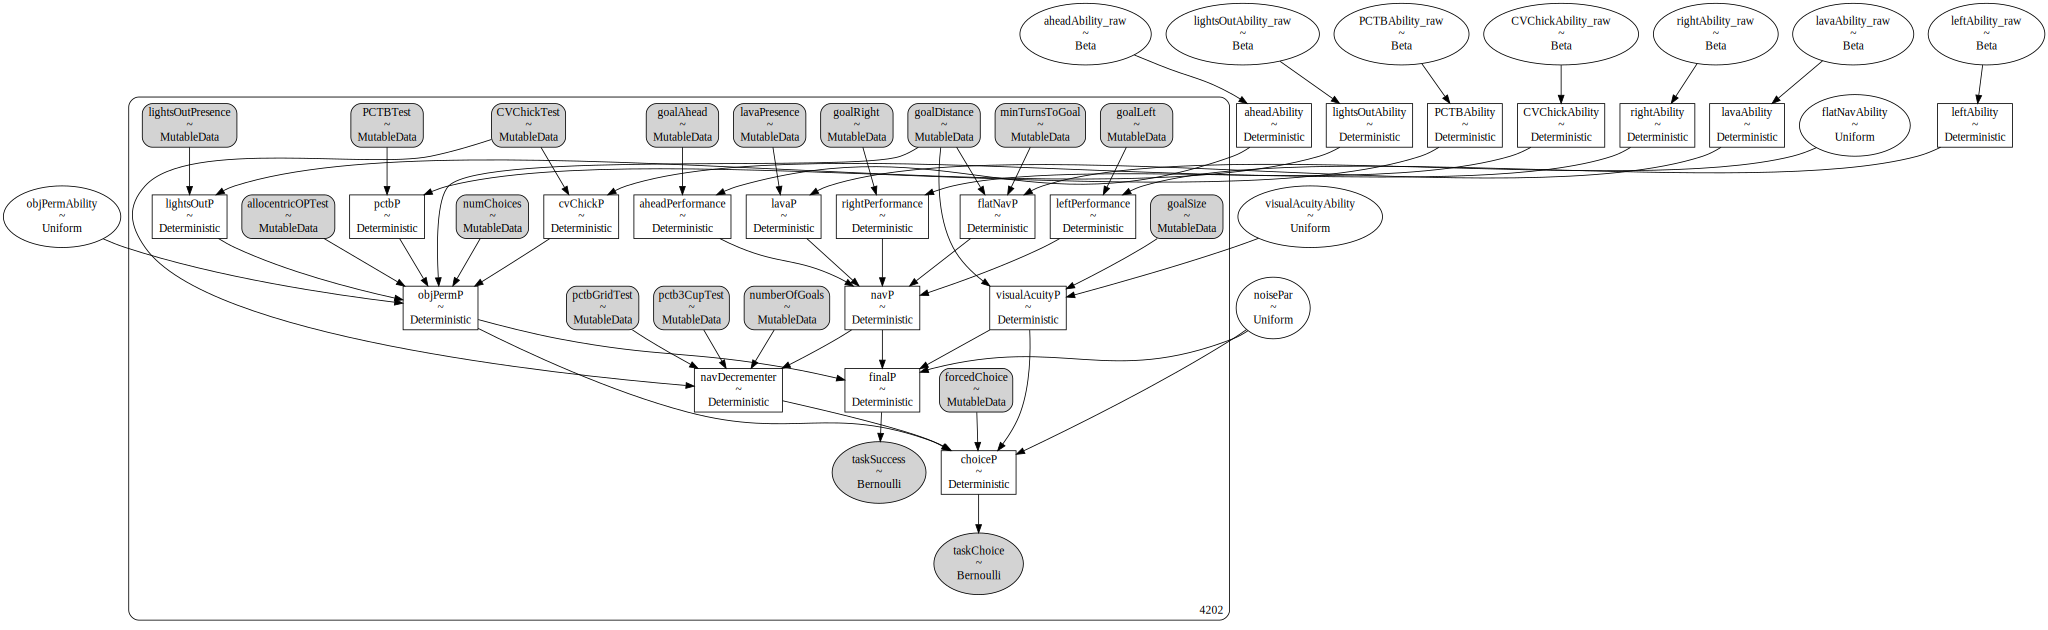

In [ ]:
m, min, max = SetupModel(agent_data, uniformAbilitySlack=1, agent_type='agent_real', agent_name="success_Vanilla_Braitenberg_15_rays_over_60_degs_356", agent_name_choice="correctChoice_Vanilla_Braitenberg_15_rays_over_60_degs_356", sample = None)
gv = pm.model_graph.model_to_graphviz(m)
gv.format = "png"
gv.render(filename='viz/FullMeasurementLayout.gv', directory='/content/drive/Shareddrives/comparative-object-permanence')
Image("/content/drive/Shareddrives/comparative-object-permanence/FullMeasurementLayout.gv.png")
gv

In [ ]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility", "rightAbility", "leftAbility", "aheadAbility", "CVChickAbility", "PCTBAbility", "lightsOutAbility", "noisePar"]
model_all, min, max = SetupModel(agent_data, uniformAbilitySlack=1, agent_type='agent_real', agent_name="success_Vanilla_Braitenberg_15_rays_over_60_degs_356", agent_name_choice="correctChoice_Vanilla_Braitenberg_15_rays_over_60_degs_356", sample = None)
with model_all:
  data_all = pm.sample(2000, target_accept=0.95)
mu, sd  = analyzeAgentResults("Vanilla_Braitenberg_15_rays_over_60_degs_356", data_all, abilitiesToShow)

In [ ]:
print(min)
print(max)
print(mu)
print(sd)

{'objPermAbility': 9.0, 'visualAcuityAbility': 1.8, 'flatNavAbility': 0.0, 'lavaAbility': 0, 'rightAbility': 0, 'leftAbility': 0, 'aheadAbility': 0, 'CVChickAbility': 0, 'PCTBAbility': 0, 'lightsOutAbility': 0}
{'objPermAbility': 708.0, 'visualAcuityAbility': 236.0, 'flatNavAbility': 1534.0, 'lavaAbility': 1, 'rightAbility': 1, 'leftAbility': 1, 'aheadAbility': 1, 'CVChickAbility': 1, 'PCTBAbility': 1, 'lightsOutAbility': 1}
{'objPermAbility': 68.27569309300593, 'visualAcuityAbility': 198.745270327514, 'flatNavAbility': 1137.0497175229125, 'lavaAbility': 0.7537853911078123, 'rightAbility': 0.776894481918848, 'leftAbility': 0.7958785684815236, 'aheadAbility': 0.7035005187385123, 'CVChickAbility': 0.8577987241964238, 'PCTBAbility': 0.0019138266445144045, 'lightsOutAbility': 0.8368260112113131, 'noisePar': 0.574183295237347}
{'objPermAbility': 10.133035488099392, 'visualAcuityAbility': 27.422028222570116, 'flatNavAbility': 220.59332712830857, 'lavaAbility': 0.16112893330874561, 'rightAbil

In [ ]:
# A function for pulling out the means and standard deviations for abilities of interest
def analyzeAgentResults(agentName, agentData, abilitiesToShow):

  #abilityMeans = [] # empty list to add in ability means to
  #abilitySDs = []

  abilityMeans = {}
  abilitySDs = {}

  for a in abilitiesToShow: #iterate through each ability, add posterior mean to dataframe, and plot posterior

    posteriorMean = float(np.mean(agentData['posterior'][a])) # calculate posterior mean
    posteriorSD = float(np.std(agentData['posterior'][a])) #calculate posterior sd
    abilityMeans[a] = posteriorMean
    abilitySDs[a] = posteriorSD
    #abilityMeans.append(posteriorMean)
    #abilitySDs.append(posteriorSD)

  return abilityMeans, abilitySDs

# A function for padding the testing data with 0s for prediction
def pad(testingData, trainingDataSize):
    return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))

# A function for making predictions based on a fitted measurement layout
def predict(m, agentData, dfTest, agent, len_training):
  with m:
    # set the data for prediction
    pm.set_data({"lavaPresence": pad(dfTest["lavaPresence"], len_training)})
    pm.set_data({"lightsOutPresence": pad(dfTest["lightsOutPresence"], len_training)})
    #pm.set_data({"rampPresence": pad(dfTest["taskCriticalRampPresence"], len_training)})
    pm.set_data({"numChoices": pad(dfTest["numChoices"], len_training)})
    pm.set_data({"minTurnsToGoal": pad(dfTest["minNumTurnsRequired"], len_training)})
    pm.set_data({"goalDistance": pad(dfTest["cityBlockDistanceToGoal"], len_training)})
    pm.set_data({"goalSize": pad(dfTest["mainGoalSize"], len_training)})
    pm.set_data({"goalRight": pad(dfTest["goalRightRelToStart"], len_training)})
    pm.set_data({"goalAhead": pad(dfTest["goalCentreRelToStart"], len_training)})
    pm.set_data({"goalLeft": pad(dfTest["goalLeftRelToStart"], len_training)})
    pm.set_data({"CVChickTest": pad(dfTest["cvchickTask"], len_training)})
    pm.set_data({"PCTBTest": pad(dfTest["pctbTask"], len_training)})
    pm.set_data({"allocentricOPTest": pad(dfTest["goalBecomesAllocentricallyOccluded"], len_training)})

    predictions=pm.sample_posterior_predictive(agentData, var_names=["finalP"], return_inferencedata=False,predictions=True,extend_inferencedata=False)
    predictionChainRuns =predictions["finalP"][:,:,0:len(dfTest)]
    predictionsInstance = np.mean(predictionChainRuns, (0,1))

    return predictionsInstance,  dfTest[agent].to_numpy()


def brierScore(preds, outs):
    return 1/len(preds) * sum( (preds-outs)**2 )

def brierDecomp(preds, outs):

  brier= 1/len(preds) * sum( (preds-outs)**2 )
  ## bin predictions
  bins = np.linspace(0,1,11)
  binCenters = (bins[:-1] +bins[1:]) /2
  binPredInds = np.digitize(preds,binCenters)
  binnedPreds = bins[binPredInds]

  binTrueFreqs = np.zeros(10)
  binPredFreqs = np.zeros(10)
  binCounts = np.zeros(10)

  for i in range(10):
      idx = (preds >= bins[i]) & (preds < bins[i+1])

      binTrueFreqs[i] = np.sum(outs[idx])/np.sum(idx) if np.sum(idx) > 0 else 0
     # print(np.sum(outs[idx]), np.sum(idx), binTrueFreqs[i])
      binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
      binCounts[i] = np.sum(idx)

  calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(binCounts)>0 else 0
  refinement = np.sum(binCounts * (binTrueFreqs *(1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(binCounts)> 0 else 0
  # Compute refinement component
  #refinement = brier - calibration
  return brier, calibration, refinement



## Run Complete Measurement Layout

In [ ]:
real_agent_names = ["Random_Walker_Fixed_Forwards_Saccade_15_Angle_10_356",
                   "Random_Walker_Fixed_Forwards_Saccade_15_Angle_10_1997",
                   "Random_Walker_Fixed_Forwards_Saccade_15_Angle_10_2023",
                   "Random_Walker_Fixed_Forwards_Saccade_15_Angle_10_1815",
                   "Random_Walker_Fixed_Forwards_Saccade_15_Angle_10_3761",
                   "Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_356",
                   "Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_1997",
                   "Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_2023",
                   "Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_1815",
                   "Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_3761",
                   "Random_Walker_Levy_Flight_Cauchy_Saccade_mode_15_Uniform_Angles_1_to_60_356",
                   "Random_Walker_Levy_Flight_Cauchy_Saccade_mode_15_Uniform_Angles_1_to_60_1997",
                   "Random_Walker_Levy_Flight_Cauchy_Saccade_mode_15_Uniform_Angles_1_to_60_2023",
                   "Random_Walker_Levy_Flight_Cauchy_Saccade_mode_15_Uniform_Angles_1_to_60_1815",
                   "Random_Walker_Levy_Flight_Cauchy_Saccade_mode_15_Uniform_Angles_1_to_60_3761",
                   "Random_Action_Agent_no_bias_no_correlation_uniform_step_length_max_20_356",
                   "Random_Action_Agent_no_bias_no_correlation_uniform_step_length_max_20_1997",
                    "Random_Action_Agent_no_bias_no_correlation_uniform_step_length_max_20_2023",
                    "Random_Action_Agent_no_bias_no_correlation_uniform_step_length_max_20_1815",
                    "Random_Action_Agent_no_bias_no_correlation_uniform_step_length_max_20_3761",
                    "Random_Action_Agent_cephalocaudal_bias_cauchy_step_length_mode_15_356",
                    "Random_Action_Agent_cephalocaudal_bias_cauchy_step_length_mode_15_1997",
                    "Random_Action_Agent_cephalocaudal_bias_cauchy_step_length_mode_15_2023",
                    "Random_Action_Agent_cephalocaudal_bias_cauchy_step_length_mode_15_1815",
                    "Random_Action_Agent_cephalocaudal_bias_cauchy_step_length_mode_15_3761",
                    "Vanilla_Braitenberg_15_rays_over_60_degs_356",
                    "Vanilla_Braitenberg_15_rays_over_60_degs_1997",
                    "Vanilla_Braitenberg_15_rays_over_60_degs_2023",
                    "Vanilla_Braitenberg_15_rays_over_60_degs_1815",
                    "Vanilla_Braitenberg_15_rays_over_60_degs_3761"]

synthetic_agent_names = ["perfectAgent",
                         "failedAgent",
                         "noOPAgent",
                         "lowVisualAcuityAgent",
                         "poorNavigationOPAgent",
                         "CVChickBasicSpecificAgent",
                         "PCTBBasicSpecificAgent"]

In [ ]:
synthetic_agents_training, synthetic_agents_test = train_test_split(synthetic_agents_data, test_size = 0.2)
real_agents_training, real_agents_test = train_test_split(agent_data, test_size=0.2)
children_training, children_test = train_test_split(children_data, test_size=0.2)
children_4_5_training, children_4_5_test = train_test_split(children_4_5_data, test_size=0.2)
children_6_7_training, children_6_7_test = train_test_split(children_6_7_data, test_size=0.2)


In [ ]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility", "rightAbility", "leftAbility", "aheadAbility", "CVChickAbility", "PCTBAbility", "lightsOutAbility", "noisePar"]

pymc_sample_num = 2000

slack = 1

In [ ]:
agentName = []
modelBrierScore = []
aggregateBrierScore = []
modelCalibration = []
aggregateCalibration = []
modelRefinement = []
aggregateRefinement = []
modelBetterThanAgg = []
meanSuccess = []
OPAbilityAllMean = []
navAbilityAllMean = []
visualAcuityAbilityAllMean = []
flatNavAbilityAllMean = []
lavaAbilityAllMean = []
rightAbilityAllMean = []
leftAbilityAllMean = []
aheadAbilityAllMean = []
CVChickAbilityAllMean = []
PCTBAbilityAllMean = []
lightsOutAbilityAllMean = []
noiseParAllMean = []
OPAbilityAllSD = []
navAbilityAllSD = []
visualAcuityAbilityAllSD = []
flatNavAbilityAllSD = []
lavaAbilityAllSD = []
rightAbilityAllSD = []
leftAbilityAllSD = []
aheadAbilityAllSD = []
CVChickAbilityAllSD = []
PCTBAbilityAllSD = []
lightsOutAbilityAllSD = []
noiseParAllSD = []
OPAbilityAllMin = []
navAbilityAllMin = []
visualAcuityAbilityAllMin = []
flatNavAbilityAllMin = []
lavaAbilityAllMin = []
rightAbilityAllMin = []
leftAbilityAllMin = []
aheadAbilityAllMin = []
CVChickAbilityAllMin = []
PCTBAbilityAllMin = []
lightsOutAbilityAllMin = []
noiseParAllMin = []
OPAbilityAllMax = []
navAbilityAllMax = []
visualAcuityAbilityAllMax = []
flatNavAbilityAllMax = []
lavaAbilityAllMax = []
rightAbilityAllMax = []
leftAbilityAllMax = []
aheadAbilityAllMax = []
CVChickAbilityAllMax = []
PCTBAbilityAllMax = []
lightsOutAbilityAllMax = []
noiseParAllMax = []

In [ ]:
for agent in synthetic_agent_names:
  model_train, min, max = SetupModel(synthetic_agents_training, uniformAbilitySlack=slack, agent_type='agent', agent_name=agent, sample = None)
  with model_train:
    data_training = pm.sample(pymc_sample_num, target_accept=0.95)

  predictions, testOutputs = predict(model_train, data_training, synthetic_agents_test, agent, len(synthetic_agents_training))
  agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
  agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(synthetic_agents_training[agent]), len(testOutputs)), testOutputs)
  aggregateBrierScore.append(agentAggBrierScore)
  aggregateCalibration.append(agentAggCalibration)
  aggregateRefinement.append(agentAggRefinement)
  modelBrierScore.append(agentBrierScore)
  modelCalibration.append(agentCalibration)
  modelRefinement.append(agentRefinement)
  if agentBrierScore < agentAggBrierScore:
    modelBetterThanAgg.append(True)
  else:
    modelBetterThanAgg.append(False)

  model_all, min, max = SetupModel(synthetic_agents_data, uniformAbilitySlack=slack, agent_type='agent', agent_name=agent, sample = None)
  with model_all:
    data_all = pm.sample(pymc_sample_num, target_accept=0.95)
  mu, sd  = analyzeAgentResults(agent, data_all, abilitiesToShow)

  OPAbilityAllMean.append(mu["objPermAbility"])
  visualAcuityAbilityAllMean.append(mu["visualAcuityAbility"])
  flatNavAbilityAllMean.append(mu["flatNavAbility"])
  lavaAbilityAllMean.append(mu["lavaAbility"])
  rightAbilityAllMean.append(mu["rightAbility"])
  leftAbilityAllMean.append(mu["leftAbility"])
  aheadAbilityAllMean.append(mu["aheadAbility"])
  CVChickAbilityAllMean.append(mu["CVChickAbility"])
  PCTBAbilityAllMean.append(mu["PCTBAbility"])
  lightsOutAbilityAllMean.append(mu["lightsOutAbility"])
  noiseParAllMean.append(mu["noisePar"])
  OPAbilityAllSD.append(sd["objPermAbility"])
  visualAcuityAbilityAllSD.append(sd["visualAcuityAbility"])
  flatNavAbilityAllSD.append(sd["flatNavAbility"])
  lavaAbilityAllSD.append(sd["lavaAbility"])
  rightAbilityAllSD.append(sd["rightAbility"])
  leftAbilityAllSD.append(sd["leftAbility"])
  aheadAbilityAllSD.append(sd["aheadAbility"])
  CVChickAbilityAllSD.append(sd["CVChickAbility"])
  PCTBAbilityAllSD.append(sd["PCTBAbility"])
  lightsOutAbilityAllSD.append(sd["lightsOutAbility"])
  noiseParAllSD.append(sd["noisePar"])
  OPAbilityAllMin.append(min["objPermAbility"])
  visualAcuityAbilityAllMin.append(min["visualAcuityAbility"])
  flatNavAbilityAllMin.append(min["flatNavAbility"])
  lavaAbilityAllMin.append(min["lavaAbility"])
  rightAbilityAllMin.append(min["rightAbility"])
  leftAbilityAllMin.append(min["leftAbility"])
  aheadAbilityAllMin.append(min["aheadAbility"])
  CVChickAbilityAllMin.append(min["CVChickAbility"])
  PCTBAbilityAllMin.append(min["PCTBAbility"])
  lightsOutAbilityAllMin.append(min["lightsOutAbility"])
  noiseParAllMin.append(0)
  OPAbilityAllMax.append(max["objPermAbility"])
  visualAcuityAbilityAllMax.append(max["visualAcuityAbility"])
  flatNavAbilityAllMax.append(max["flatNavAbility"])
  lavaAbilityAllMax.append(max["lavaAbility"])
  rightAbilityAllMax.append(max["rightAbility"])
  leftAbilityAllMax.append(max["leftAbility"])
  aheadAbilityAllMax.append(max["aheadAbility"])
  CVChickAbilityAllMax.append(max["CVChickAbility"])
  PCTBAbilityAllMax.append(max["PCTBAbility"])
  lightsOutAbilityAllMax.append(max["lightsOutAbility"])
  noiseParAllMax.append(1)

  meanSuccess.append(np.mean(synthetic_agents_data[agent]))
  agentName.append(agent)

  finalDF = pd.DataFrame({"Agent Name": agentName,
                          "Model Brier Score":modelBrierScore,
                          "Aggregate Brier Scores": aggregateBrierScore,
                          "Model Calibration": modelCalibration,
                          "Aggregate Calibration":aggregateCalibration,
                          "Model Refinement":modelRefinement,
                          "Aggregate Refinement":aggregateRefinement,
                          "Model Better? (Based on Brier Score)":modelBetterThanAgg,
                          "Success Score":meanSuccess,
                          "Object Permanence Ability Mean (All)": OPAbilityAllMean,
                          "Visual Acuity Ability Mean (All)" : visualAcuityAbilityAllMean,
                          "Flat Navigation Ability Mean (All)" : flatNavAbilityAllMean,
                          "Lava Ability Mean (All)" : lavaAbilityAllMean,
                          "Right Ability Mean (All)" : rightAbilityAllMean,
                          "Left Ability Mean (All)" : leftAbilityAllMean,
                          "Ahead Ability Mean (All)" : aheadAbilityAllMean,
                          "CVChick Ability Mean (All)" : CVChickAbilityAllMean,
                          "PCTB Ability Mean (All)" :  PCTBAbilityAllMean,
                          "Lights Out Ability Mean (All)" : lightsOutAbilityAllMean,
                          "Noise Parameter Mean (All)" : noiseParAllMean,
                          "Object Permanence Ability SD (All)": OPAbilityAllSD,
                          "Visual Acuity Ability SD (All)" : visualAcuityAbilityAllSD,
                          "Flat Navigation Ability SD (All)" : flatNavAbilityAllSD,
                          "Lava Ability SD (All)" : lavaAbilityAllSD,
                          "Right Ability SD (All)" : rightAbilityAllSD,
                          "Left Ability SD (All)" : leftAbilityAllSD,
                          "Ahead Ability SD (All)" : aheadAbilityAllSD,
                          "CVChick Ability SD (All)" : CVChickAbilityAllSD,
                          "PCTB Ability SD (All)" :  PCTBAbilityAllSD,
                          "Lights Out Ability SD (All)" : lightsOutAbilityAllSD,
                          "Noise Parameter SD (All)" : noiseParAllSD,
                          "Object Permanence Ability Min (All)": OPAbilityAllMin,
                          "Visual Acuity Ability Min (All)" : visualAcuityAbilityAllMin,
                          "Flat Navigation Ability Min (All)" : flatNavAbilityAllMin,
                          "Lava Ability Min (All)" : lavaAbilityAllMin,
                          "Right Ability Min (All)" : rightAbilityAllMin,
                          "Left Ability Min (All)" : leftAbilityAllMin,
                          "Ahead Ability Min (All)" : aheadAbilityAllMin,
                          "CVChick Ability Min (All)" : CVChickAbilityAllMin,
                          "PCTB Ability Min (All)" :  PCTBAbilityAllMin,
                          "Lights Out Ability Min (All)" : lightsOutAbilityAllMin,
                          "Noise Parameter Min (All)" : noiseParAllMin,
                          "Object Permanence Ability Max (All)": OPAbilityAllMax,
                          "Visual Acuity Ability Max (All)" : visualAcuityAbilityAllMax,
                          "Flat Navigation Ability Max (All)" : flatNavAbilityAllMax,
                          "Lava Ability Max (All)" : lavaAbilityAllMax,
                          "Right Ability Max (All)" : rightAbilityAllMax,
                          "Left Ability Max (All)" : leftAbilityAllMax,
                          "Ahead Ability Max (All)" : aheadAbilityAllMax,
                          "CVChick Ability Max (All)" : CVChickAbilityAllMax,
                          "PCTB Ability Max (All)" :  PCTBAbilityAllMax,
                          "Lights Out Ability Max (All)" : lightsOutAbilityAllMax,
                          "Noise Parameter Max (All)" : noiseParAllMax})
  finalDF.to_csv("/content/drive/Shareddrives/comparative-object-permanence/finalResults.csv", index = False)

In [ ]:
for agent in real_agent_names:
  model_train, min, max = SetupModel(real_agents_training, uniformAbilitySlack=slack, agent_type='agent', agent_name=agent, sample = None)
  with model_train:
    data_training = pm.sample(pymc_sample_num, target_accept=0.95)

  predictions, testOutputs = predict(model_train, data_training, real_agents_test, agent, len(real_agents_training))
  agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
  agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(real_agents_training[agent]), len(testOutputs)), testOutputs)
  aggregateBrierScore.append(agentAggBrierScore)
  aggregateCalibration.append(agentAggCalibration)
  aggregateRefinement.append(agentAggRefinement)
  modelBrierScore.append(agentBrierScore)
  modelCalibration.append(agentCalibration)
  modelRefinement.append(agentRefinement)
  if agentBrierScore < agentAggBrierScore:
    modelBetterThanAgg.append(True)
  else:
    modelBetterThanAgg.append(False)

  model_all, min, max = SetupModel(agent_data, uniformAbilitySlack=slack, agent_type='agent', agent_name=agent, sample = None)
  with model_all:
    data_all = pm.sample(pymc_sample_num, target_accept=0.95)
  mu, sd  = analyzeAgentResults(agent, data_all, abilitiesToShow)

  OPAbilityAllMean.append(mu["objPermAbility"])
  visualAcuityAbilityAllMean.append(mu["visualAcuityAbility"])
  flatNavAbilityAllMean.append(mu["flatNavAbility"])
  lavaAbilityAllMean.append(mu["lavaAbility"])
  rightAbilityAllMean.append(mu["rightAbility"])
  leftAbilityAllMean.append(mu["leftAbility"])
  aheadAbilityAllMean.append(mu["aheadAbility"])
  CVChickAbilityAllMean.append(mu["CVChickAbility"])
  PCTBAbilityAllMean.append(mu["PCTBAbility"])
  lightsOutAbilityAllMean.append(mu["lightsOutAbility"])
  noiseParAllMean.append(mu["noisePar"])
  OPAbilityAllSD.append(sd["objPermAbility"])
  visualAcuityAbilityAllSD.append(sd["visualAcuityAbility"])
  flatNavAbilityAllSD.append(sd["flatNavAbility"])
  lavaAbilityAllSD.append(sd["lavaAbility"])
  rightAbilityAllSD.append(sd["rightAbility"])
  leftAbilityAllSD.append(sd["leftAbility"])
  aheadAbilityAllSD.append(sd["aheadAbility"])
  CVChickAbilityAllSD.append(sd["CVChickAbility"])
  PCTBAbilityAllSD.append(sd["PCTBAbility"])
  lightsOutAbilityAllSD.append(sd["lightsOutAbility"])
  noiseParAllSD.append(sd["noisePar"])
  OPAbilityAllMin.append(min["objPermAbility"])
  visualAcuityAbilityAllMin.append(min["visualAcuityAbility"])
  flatNavAbilityAllMin.append(min["flatNavAbility"])
  lavaAbilityAllMin.append(min["lavaAbility"])
  rightAbilityAllMin.append(min["rightAbility"])
  leftAbilityAllMin.append(min["leftAbility"])
  aheadAbilityAllMin.append(min["aheadAbility"])
  CVChickAbilityAllMin.append(min["CVChickAbility"])
  PCTBAbilityAllMin.append(min["PCTBAbility"])
  lightsOutAbilityAllMin.append(min["lightsOutAbility"])
  noiseParAllMin.append(0)
  OPAbilityAllMax.append(max["objPermAbility"])
  visualAcuityAbilityAllMax.append(max["visualAcuityAbility"])
  flatNavAbilityAllMax.append(max["flatNavAbility"])
  lavaAbilityAllMax.append(max["lavaAbility"])
  rightAbilityAllMax.append(max["rightAbility"])
  leftAbilityAllMax.append(max["leftAbility"])
  aheadAbilityAllMax.append(max["aheadAbility"])
  CVChickAbilityAllMax.append(max["CVChickAbility"])
  PCTBAbilityAllMax.append(max["PCTBAbility"])
  lightsOutAbilityAllMax.append(max["lightsOutAbility"])
  noiseParAllMax.append(1)

  meanSuccess.append(np.mean(agent_data[agent]))
  agentName.append(agent)

  finalDF = pd.DataFrame({"Agent Name": agentName,
                          "Model Brier Score":modelBrierScore,
                          "Aggregate Brier Scores": aggregateBrierScore,
                          "Model Calibration": modelCalibration,
                          "Aggregate Calibration":aggregateCalibration,
                          "Model Refinement":modelRefinement,
                          "Aggregate Refinement":aggregateRefinement,
                          "Model Better? (Based on Brier Score)":modelBetterThanAgg,
                          "Success Score":meanSuccess,
                          "Object Permanence Ability Mean (All)": OPAbilityAllMean,
                          "Visual Acuity Ability Mean (All)" : visualAcuityAbilityAllMean,
                          "Flat Navigation Ability Mean (All)" : flatNavAbilityAllMean,
                          "Lava Ability Mean (All)" : lavaAbilityAllMean,
                          "Right Ability Mean (All)" : rightAbilityAllMean,
                          "Left Ability Mean (All)" : leftAbilityAllMean,
                          "Ahead Ability Mean (All)" : aheadAbilityAllMean,
                          "CVChick Ability Mean (All)" : CVChickAbilityAllMean,
                          "PCTB Ability Mean (All)" :  PCTBAbilityAllMean,
                          "Lights Out Ability Mean (All)" : lightsOutAbilityAllMean,
                          "Noise Parameter Mean (All)" : noiseParAllMean,
                          "Object Permanence Ability SD (All)": OPAbilityAllSD,
                          "Visual Acuity Ability SD (All)" : visualAcuityAbilityAllSD,
                          "Flat Navigation Ability SD (All)" : flatNavAbilityAllSD,
                          "Lava Ability SD (All)" : lavaAbilityAllSD,
                          "Right Ability SD (All)" : rightAbilityAllSD,
                          "Left Ability SD (All)" : leftAbilityAllSD,
                          "Ahead Ability SD (All)" : aheadAbilityAllSD,
                          "CVChick Ability SD (All)" : CVChickAbilityAllSD,
                          "PCTB Ability SD (All)" :  PCTBAbilityAllSD,
                          "Lights Out Ability SD (All)" : lightsOutAbilityAllSD,
                          "Noise Parameter SD (All)" : noiseParAllSD,
                          "Object Permanence Ability Min (All)": OPAbilityAllMin,
                          "Visual Acuity Ability Min (All)" : visualAcuityAbilityAllMin,
                          "Flat Navigation Ability Min (All)" : flatNavAbilityAllMin,
                          "Lava Ability Min (All)" : lavaAbilityAllMin,
                          "Right Ability Min (All)" : rightAbilityAllMin,
                          "Left Ability Min (All)" : leftAbilityAllMin,
                          "Ahead Ability Min (All)" : aheadAbilityAllMin,
                          "CVChick Ability Min (All)" : CVChickAbilityAllMin,
                          "PCTB Ability Min (All)" :  PCTBAbilityAllMin,
                          "Lights Out Ability Min (All)" : lightsOutAbilityAllMin,
                          "Noise Parameter Min (All)" : noiseParAllMin,
                          "Object Permanence Ability Max (All)": OPAbilityAllMax,
                          "Visual Acuity Ability Max (All)" : visualAcuityAbilityAllMax,
                          "Flat Navigation Ability Max (All)" : flatNavAbilityAllMax,
                          "Lava Ability Max (All)" : lavaAbilityAllMax,
                          "Right Ability Max (All)" : rightAbilityAllMax,
                          "Left Ability Max (All)" : leftAbilityAllMax,
                          "Ahead Ability Max (All)" : aheadAbilityAllMax,
                          "CVChick Ability Max (All)" : CVChickAbilityAllMax,
                          "PCTB Ability Max (All)" :  PCTBAbilityAllMax,
                          "Lights Out Ability Max (All)" : lightsOutAbilityAllMax,
                          "Noise Parameter Max (All)" : noiseParAllMax})
  finalDF.to_csv("/content/drive/Shareddrives/comparative-object-permanence/finalResults.csv", index = False)

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

In [ ]:
model_train, min, max = SetupModel(children_training, uniformAbilitySlack=slack, agent_type='child', agent_name=agent, sample = None)
with model_train:
  data_training = pm.sample(pymc_sample_num, target_accept=0.95)

predictions, testOutputs = predict(model_train, data_training, children_test, 'success', len(children_training))
agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(children_training['success']), len(testOutputs)), testOutputs)
aggregateBrierScore.append(agentAggBrierScore)
aggregateCalibration.append(agentAggCalibration)
aggregateRefinement.append(agentAggRefinement)
modelBrierScore.append(agentBrierScore)
modelCalibration.append(agentCalibration)
modelRefinement.append(agentRefinement)
if agentBrierScore < agentAggBrierScore:
  modelBetterThanAgg.append(True)
else:
  modelBetterThanAgg.append(False)

model_all, min, max = SetupModel(children_data, uniformAbilitySlack=slack, agent_type='child', sample = None)
with model_all:
  data_all = pm.sample(pymc_sample_num, target_accept=0.95)
mu, sd  = analyzeAgentResults("child", data_all, abilitiesToShow)

OPAbilityAllMean.append(mu["objPermAbility"])
visualAcuityAbilityAllMean.append(mu["visualAcuityAbility"])
flatNavAbilityAllMean.append(mu["flatNavAbility"])
lavaAbilityAllMean.append(mu["lavaAbility"])
rightAbilityAllMean.append(mu["rightAbility"])
leftAbilityAllMean.append(mu["leftAbility"])
aheadAbilityAllMean.append(mu["aheadAbility"])
CVChickAbilityAllMean.append(mu["CVChickAbility"])
PCTBAbilityAllMean.append(mu["PCTBAbility"])
lightsOutAbilityAllMean.append(mu["lightsOutAbility"])
noiseParAllMean.append(mu["noisePar"])
OPAbilityAllSD.append(sd["objPermAbility"])
visualAcuityAbilityAllSD.append(sd["visualAcuityAbility"])
flatNavAbilityAllSD.append(sd["flatNavAbility"])
lavaAbilityAllSD.append(sd["lavaAbility"])
rightAbilityAllSD.append(sd["rightAbility"])
leftAbilityAllSD.append(sd["leftAbility"])
aheadAbilityAllSD.append(sd["aheadAbility"])
CVChickAbilityAllSD.append(sd["CVChickAbility"])
PCTBAbilityAllSD.append(sd["PCTBAbility"])
lightsOutAbilityAllSD.append(sd["lightsOutAbility"])
noiseParAllSD.append(sd["noisePar"])
OPAbilityAllMin.append(min["objPermAbility"])
visualAcuityAbilityAllMin.append(min["visualAcuityAbility"])
flatNavAbilityAllMin.append(min["flatNavAbility"])
lavaAbilityAllMin.append(min["lavaAbility"])
rightAbilityAllMin.append(min["rightAbility"])
leftAbilityAllMin.append(min["leftAbility"])
aheadAbilityAllMin.append(min["aheadAbility"])
CVChickAbilityAllMin.append(min["CVChickAbility"])
PCTBAbilityAllMin.append(min["PCTBAbility"])
lightsOutAbilityAllMin.append(min["lightsOutAbility"])
noiseParAllMin.append(0)
OPAbilityAllMax.append(max["objPermAbility"])
visualAcuityAbilityAllMax.append(max["visualAcuityAbility"])
flatNavAbilityAllMax.append(max["flatNavAbility"])
lavaAbilityAllMax.append(max["lavaAbility"])
rightAbilityAllMax.append(max["rightAbility"])
leftAbilityAllMax.append(max["leftAbility"])
aheadAbilityAllMax.append(max["aheadAbility"])
CVChickAbilityAllMax.append(max["CVChickAbility"])
PCTBAbilityAllMax.append(max["PCTBAbility"])
lightsOutAbilityAllMax.append(max["lightsOutAbility"])
noiseParAllMax.append(1)

meanSuccess.append(np.mean(children_data['success']))
agentName.append('children')

finalDF = pd.DataFrame({"Agent Name": agentName,
                        "Model Brier Score":modelBrierScore,
                        "Aggregate Brier Scores": aggregateBrierScore,
                        "Model Calibration": modelCalibration,
                        "Aggregate Calibration":aggregateCalibration,
                        "Model Refinement":modelRefinement,
                        "Aggregate Refinement":aggregateRefinement,
                        "Model Better? (Based on Brier Score)":modelBetterThanAgg,
                        "Success Score":meanSuccess,
                        "Object Permanence Ability Mean (All)": OPAbilityAllMean,
                        "Visual Acuity Ability Mean (All)" : visualAcuityAbilityAllMean,
                        "Flat Navigation Ability Mean (All)" : flatNavAbilityAllMean,
                        "Lava Ability Mean (All)" : lavaAbilityAllMean,
                        "Right Ability Mean (All)" : rightAbilityAllMean,
                        "Left Ability Mean (All)" : leftAbilityAllMean,
                        "Ahead Ability Mean (All)" : aheadAbilityAllMean,
                        "CVChick Ability Mean (All)" : CVChickAbilityAllMean,
                        "PCTB Ability Mean (All)" :  PCTBAbilityAllMean,
                        "Lights Out Ability Mean (All)" : lightsOutAbilityAllMean,
                        "Noise Parameter Mean (All)" : noiseParAllMean,
                        "Object Permanence Ability SD (All)": OPAbilityAllSD,
                        "Visual Acuity Ability SD (All)" : visualAcuityAbilityAllSD,
                        "Flat Navigation Ability SD (All)" : flatNavAbilityAllSD,
                        "Lava Ability SD (All)" : lavaAbilityAllSD,
                        "Right Ability SD (All)" : rightAbilityAllSD,
                        "Left Ability SD (All)" : leftAbilityAllSD,
                        "Ahead Ability SD (All)" : aheadAbilityAllSD,
                        "CVChick Ability SD (All)" : CVChickAbilityAllSD,
                        "PCTB Ability SD (All)" :  PCTBAbilityAllSD,
                        "Lights Out Ability SD (All)" : lightsOutAbilityAllSD,
                        "Noise Parameter SD (All)" : noiseParAllSD,
                        "Object Permanence Ability Min (All)": OPAbilityAllMin,
                        "Visual Acuity Ability Min (All)" : visualAcuityAbilityAllMin,
                        "Flat Navigation Ability Min (All)" : flatNavAbilityAllMin,
                        "Lava Ability Min (All)" : lavaAbilityAllMin,
                        "Right Ability Min (All)" : rightAbilityAllMin,
                        "Left Ability Min (All)" : leftAbilityAllMin,
                        "Ahead Ability Min (All)" : aheadAbilityAllMin,
                        "CVChick Ability Min (All)" : CVChickAbilityAllMin,
                        "PCTB Ability Min (All)" :  PCTBAbilityAllMin,
                        "Lights Out Ability Min (All)" : lightsOutAbilityAllMin,
                        "Noise Parameter Min (All)" : noiseParAllMin,
                        "Object Permanence Ability Max (All)": OPAbilityAllMax,
                        "Visual Acuity Ability Max (All)" : visualAcuityAbilityAllMax,
                        "Flat Navigation Ability Max (All)" : flatNavAbilityAllMax,
                        "Lava Ability Max (All)" : lavaAbilityAllMax,
                        "Right Ability Max (All)" : rightAbilityAllMax,
                        "Left Ability Max (All)" : leftAbilityAllMax,
                        "Ahead Ability Max (All)" : aheadAbilityAllMax,
                        "CVChick Ability Max (All)" : CVChickAbilityAllMax,
                        "PCTB Ability Max (All)" :  PCTBAbilityAllMax,
                        "Lights Out Ability Max (All)" : lightsOutAbilityAllMax,
                        "Noise Parameter Max (All)" : noiseParAllMax})
#finalDF.to_csv("/content/drive/Shareddrives/comparative-object-permanence/finalResults.csv", index = False)


<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-8-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(n

In [ ]:
with open('/content/drive/Shareddrives/comparative-object-permanence/finalResults.pkl', 'wb') as f:
      pickle.dump(finalDF, f)

In [ ]:
## Not run: in case evaluation stops.
# with open('/content/drive/Shareddrives/comparative-object-permanence/finalResults.pkl', 'rb') as f:
#       originaldata = pickle.load(f)
# output = pd.concat([originaldata, finalDF], axis = 0)

In [ ]:
model_train, min, max = SetupModel(children_4_5_training, uniformAbilitySlack=slack, agent_type='child', agent_name="children_4_5", sample = None)
with model_train:
  data_training = pm.sample(pymc_sample_num, target_accept=0.95)

predictions, testOutputs = predict(model_train, data_training, children_4_5_test, 'success', len(children_training))
agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(children_4_5_training['success']), len(testOutputs)), testOutputs)
aggregateBrierScore.append(agentAggBrierScore)
aggregateCalibration.append(agentAggCalibration)
aggregateRefinement.append(agentAggRefinement)
modelBrierScore.append(agentBrierScore)
modelCalibration.append(agentCalibration)
modelRefinement.append(agentRefinement)
if agentBrierScore < agentAggBrierScore:
  modelBetterThanAgg.append(True)
else:
  modelBetterThanAgg.append(False)

model_all, min, max = SetupModel(children_4_5_data, uniformAbilitySlack=slack, agent_type='child', sample = None)
with model_all:
  data_all = pm.sample(pymc_sample_num, target_accept=0.95)
mu, sd  = analyzeAgentResults("child_4_5", data_all, abilitiesToShow)

OPAbilityAllMean.append(mu["objPermAbility"])
visualAcuityAbilityAllMean.append(mu["visualAcuityAbility"])
flatNavAbilityAllMean.append(mu["flatNavAbility"])
lavaAbilityAllMean.append(mu["lavaAbility"])
rightAbilityAllMean.append(mu["rightAbility"])
leftAbilityAllMean.append(mu["leftAbility"])
aheadAbilityAllMean.append(mu["aheadAbility"])
CVChickAbilityAllMean.append(mu["CVChickAbility"])
PCTBAbilityAllMean.append(mu["PCTBAbility"])
lightsOutAbilityAllMean.append(mu["lightsOutAbility"])
noiseParAllMean.append(mu["noisePar"])
OPAbilityAllSD.append(sd["objPermAbility"])
visualAcuityAbilityAllSD.append(sd["visualAcuityAbility"])
flatNavAbilityAllSD.append(sd["flatNavAbility"])
lavaAbilityAllSD.append(sd["lavaAbility"])
rightAbilityAllSD.append(sd["rightAbility"])
leftAbilityAllSD.append(sd["leftAbility"])
aheadAbilityAllSD.append(sd["aheadAbility"])
CVChickAbilityAllSD.append(sd["CVChickAbility"])
PCTBAbilityAllSD.append(sd["PCTBAbility"])
lightsOutAbilityAllSD.append(sd["lightsOutAbility"])
noiseParAllSD.append(sd["noisePar"])
OPAbilityAllMin.append(min["objPermAbility"])
visualAcuityAbilityAllMin.append(min["visualAcuityAbility"])
flatNavAbilityAllMin.append(min["flatNavAbility"])
lavaAbilityAllMin.append(min["lavaAbility"])
rightAbilityAllMin.append(min["rightAbility"])
leftAbilityAllMin.append(min["leftAbility"])
aheadAbilityAllMin.append(min["aheadAbility"])
CVChickAbilityAllMin.append(min["CVChickAbility"])
PCTBAbilityAllMin.append(min["PCTBAbility"])
lightsOutAbilityAllMin.append(min["lightsOutAbility"])
noiseParAllMin.append(0)
OPAbilityAllMax.append(max["objPermAbility"])
visualAcuityAbilityAllMax.append(max["visualAcuityAbility"])
flatNavAbilityAllMax.append(max["flatNavAbility"])
lavaAbilityAllMax.append(max["lavaAbility"])
rightAbilityAllMax.append(max["rightAbility"])
leftAbilityAllMax.append(max["leftAbility"])
aheadAbilityAllMax.append(max["aheadAbility"])
CVChickAbilityAllMax.append(max["CVChickAbility"])
PCTBAbilityAllMax.append(max["PCTBAbility"])
lightsOutAbilityAllMax.append(max["lightsOutAbility"])
noiseParAllMax.append(1)

meanSuccess.append(np.mean(children_4_5_data['success']))
agentName.append('children')

finalDF = pd.DataFrame({"Agent Name": agentName,
                        "Model Brier Score":modelBrierScore,
                        "Aggregate Brier Scores": aggregateBrierScore,
                        "Model Calibration": modelCalibration,
                        "Aggregate Calibration":aggregateCalibration,
                        "Model Refinement":modelRefinement,
                        "Aggregate Refinement":aggregateRefinement,
                        "Model Better? (Based on Brier Score)":modelBetterThanAgg,
                        "Success Score":meanSuccess,
                        "Object Permanence Ability Mean (All)": OPAbilityAllMean,
                        "Visual Acuity Ability Mean (All)" : visualAcuityAbilityAllMean,
                        "Flat Navigation Ability Mean (All)" : flatNavAbilityAllMean,
                        "Lava Ability Mean (All)" : lavaAbilityAllMean,
                        "Right Ability Mean (All)" : rightAbilityAllMean,
                        "Left Ability Mean (All)" : leftAbilityAllMean,
                        "Ahead Ability Mean (All)" : aheadAbilityAllMean,
                        "CVChick Ability Mean (All)" : CVChickAbilityAllMean,
                        "PCTB Ability Mean (All)" :  PCTBAbilityAllMean,
                        "Lights Out Ability Mean (All)" : lightsOutAbilityAllMean,
                        "Noise Parameter Mean (All)" : noiseParAllMean,
                        "Object Permanence Ability SD (All)": OPAbilityAllSD,
                        "Visual Acuity Ability SD (All)" : visualAcuityAbilityAllSD,
                        "Flat Navigation Ability SD (All)" : flatNavAbilityAllSD,
                        "Lava Ability SD (All)" : lavaAbilityAllSD,
                        "Right Ability SD (All)" : rightAbilityAllSD,
                        "Left Ability SD (All)" : leftAbilityAllSD,
                        "Ahead Ability SD (All)" : aheadAbilityAllSD,
                        "CVChick Ability SD (All)" : CVChickAbilityAllSD,
                        "PCTB Ability SD (All)" :  PCTBAbilityAllSD,
                        "Lights Out Ability SD (All)" : lightsOutAbilityAllSD,
                        "Noise Parameter SD (All)" : noiseParAllSD,
                        "Object Permanence Ability Min (All)": OPAbilityAllMin,
                        "Visual Acuity Ability Min (All)" : visualAcuityAbilityAllMin,
                        "Flat Navigation Ability Min (All)" : flatNavAbilityAllMin,
                        "Lava Ability Min (All)" : lavaAbilityAllMin,
                        "Right Ability Min (All)" : rightAbilityAllMin,
                        "Left Ability Min (All)" : leftAbilityAllMin,
                        "Ahead Ability Min (All)" : aheadAbilityAllMin,
                        "CVChick Ability Min (All)" : CVChickAbilityAllMin,
                        "PCTB Ability Min (All)" :  PCTBAbilityAllMin,
                        "Lights Out Ability Min (All)" : lightsOutAbilityAllMin,
                        "Noise Parameter Min (All)" : noiseParAllMin,
                        "Object Permanence Ability Max (All)": OPAbilityAllMax,
                        "Visual Acuity Ability Max (All)" : visualAcuityAbilityAllMax,
                        "Flat Navigation Ability Max (All)" : flatNavAbilityAllMax,
                        "Lava Ability Max (All)" : lavaAbilityAllMax,
                        "Right Ability Max (All)" : rightAbilityAllMax,
                        "Left Ability Max (All)" : leftAbilityAllMax,
                        "Ahead Ability Max (All)" : aheadAbilityAllMax,
                        "CVChick Ability Max (All)" : CVChickAbilityAllMax,
                        "PCTB Ability Max (All)" :  PCTBAbilityAllMax,
                        "Lights Out Ability Max (All)" : lightsOutAbilityAllMax,
                        "Noise Parameter Max (All)" : noiseParAllMax})
#finalDF.to_csv("/content/drive/Shareddrives/comparative-object-permanence/finalResults.csv", index = False)


<ipython-input-14-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-14-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-14-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-14-175c2f4f91ba>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Seri

In [ ]:
finalDF

,Agent Name,Model Brier Score,Aggregate Brier Scores,Model Calibration,Aggregate Calibration,Model Refinement,Aggregate Refinement,Model Better? (Based on Brier Score),Success Score,Object Permanence Ability Mean (All),...,Visual Acuity Ability Max (All),Flat Navigation Ability Max (All),Lava Ability Max (All),Right Ability Max (All),Left Ability Max (All),Ahead Ability Max (All),CVChick Ability Max (All),PCTB Ability Max (All),Lights Out Ability Max (All),Noise Parameter Max (All)
0,children,0.213122,0.227944,0.010251,0.00422,0.202191,0.223723,True,0.714024,677.493221,...,78.666667,1534.0,2,2,2,2,2,2,2,1


In [42]:
def SetupHierarchicalModel(taskResults, uniformAbilitySlack = 1):
  """
  taskResults is the conjunction of the metadata with the successes of the agents on that set of tests.
  """
  assert uniformAbilitySlack >=1, "Slack must be greater than or equal to 1."

  # if agent_type == "agent_real":
  #   taskResults = taskResultsAll.dropna(subset = [agent_name])
  #   if sample is not None:
  #     taskResults = taskResults.sample(n=sample)
  #   results = taskResults[agent_name]
  #   choices = taskResults[agent_name_choice]
  # elif agent_type == "agent_synthetic":
  #   taskResults = taskResultsAll.dropna(subset = [agent_name])
  #   if sample is not None:
  #     taskResults = taskResults.sample(n=sample)
  #   results = taskResults[agent_name]
  #   choices = results
  # elif agent_type == "child":
  #   taskResults = taskResultsAll.dropna(subset = ['success'])
  #   if sample is not None:
  #     taskResults = taskResults.sample(n=sample)
  #   results = taskResults['success']
  #   choices = taskResults['correctChoice']
  # else:
  #   print("Agent not recognised. Quitting.")
  #   return


  agent_idx, agents = taskResults['agent_tag'].factorize(sort=True)

  COORDS = {
    'obs': taskResults.index,
    'agent': agents ##only by type of agent, not by random seed.
    }

  abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
  abilityMax = {}

  #Decide "maximum capabilities" based on the hardest values in the dataset
  maxDistance = taskResults["cityBlockDistanceToGoal"].max()
  maxTurns = taskResults["minNumTurnsRequired"].max()
  maxChoices = taskResults["numChoices"].max()
  maxGoalSize = taskResults["mainGoalSize"].max() * uniformAbilitySlack
  maxPermAbility = ((taskResults["cityBlockDistanceToGoal"] * taskResults["numChoices"]).max()) * uniformAbilitySlack
  maxFlatNav = ((taskResults["cityBlockDistanceToGoal"]*taskResults["minNumTurnsRequired"])).max() * uniformAbilitySlack
  #maxPermAbility = maxChoices * uniformAbilitySlack
  #maxMemoryAbility = maxDistance * uniformAbilitySlack
  #maxPermAbility = 1
  #maxMemoryAbility = 1

  # Decide 'minimum capabilities' based on easiest values in the dataset
  minDistance = taskResults["cityBlockDistanceToGoal"].min()
  minTurns = taskResults["minNumTurnsRequired"].min()
  minChoices = taskResults["numChoices"].min()
  minGoalSize = taskResults["mainGoalSize"].min() * (1-(uniformAbilitySlack-1))
  minPermAbility = ((taskResults["cityBlockDistanceToGoal"] * taskResults["numChoices"]).min()) * (1-(uniformAbilitySlack-1))
  minFlatNav = ((taskResults["cityBlockDistanceToGoal"]*taskResults["minNumTurnsRequired"])).min() * (1-(uniformAbilitySlack-1))
  #minPermAbility = 0

  m = pm.Model(coords=COORDS)
  with m:

    #### Hyper priors ####
    V_Lava = pm.Beta('V_Lava', 1, 1)
    U_Lava = pm.HalfNormal('U_Lava',sigma = 10)
    V_Ahead = pm.Beta('V_Ahead', 1, 1)
    U_Ahead = pm.HalfNormal('U_Ahead',sigma = 10)
    V_Left = pm.Beta('V_Left', 1, 1)
    U_Left = pm.HalfNormal('U_Left',sigma = 10)
    V_Right = pm.Beta('V_Right', 1, 1)
    U_Right = pm.HalfNormal('U_Right',sigma = 10)
    V_CVChick = pm.Beta('V_CVChick', 1, 1)
    U_CVChick = pm.HalfNormal('U_CVChick',sigma = 10)
    V_PCTB = pm.Beta('V_PCTB', 1, 1)
    U_PCTB = pm.HalfNormal('U_PCTB',sigma = 10)
    V_LightsOut = pm.Beta('V_LightsOut', 1, 1)
    U_LightsOut = pm.HalfNormal('U_LightsOut',sigma = 10)

    V_OP = pm.Beta('V_OP', 1, 1)
    U_OP = pm.HalfNormal('U_OP',sigma = 10)
    V_VisualAcuity = pm.Beta('V_VisualAcuity', 1, 1)
    U_VisualAcuity = pm.HalfNormal('U_VisualAcuity',sigma = 10)
    V_FlatNav = pm.Beta('V_FlatNav', 1, 1)
    U_FlatNav = pm.HalfNormal('U_FlatNav',sigma = 10)

    ##ignore noise for now.

    ### Ability Priors as scaled beta distributions
    al_Lava = pm.Deterministic('al_Lava', V_Lava * U_Lava)
    be_Lava = pm.Deterministic('be_Lava', (1-V_Lava) * U_Lava)
    al_Ahead = pm.Deterministic('al_Ahead', V_Ahead * U_Ahead)
    be_Ahead = pm.Deterministic('be_Ahead', (1-V_Ahead) * U_Ahead)
    al_Left = pm.Deterministic('al_Left', V_Left * U_Left)
    be_Left = pm.Deterministic('be_Left', (1-V_Left) * U_Left)
    al_Right = pm.Deterministic('al_Right', V_Right * U_Right)
    be_Right = pm.Deterministic('be_Right', (1-V_Right) * U_Right)
    al_CVChick = pm.Deterministic('al_CVChick', V_CVChick * U_CVChick)
    be_CVChick = pm.Deterministic('be_CVChick', (1-V_CVChick) * U_CVChick)
    al_PCTB = pm.Deterministic('al_PCTB', V_PCTB * U_PCTB)
    be_PCTB = pm.Deterministic('be_PCTB', (1-V_PCTB) * U_PCTB)
    al_LightsOut = pm.Deterministic('al_LightsOut', V_LightsOut * U_LightsOut)
    be_LightsOut = pm.Deterministic('be_LightsOut', (1-V_LightsOut) * U_LightsOut)

    al_OP = pm.Deterministic('al_OP', V_OP * U_OP)
    be_OP = pm.Deterministic('be_OP', (1-V_OP) * U_OP)
    al_VisualAcuity = pm.Deterministic('al_VisualAcuity', V_VisualAcuity * U_VisualAcuity)
    be_VisualAcuity = pm.Deterministic('be_VisualAcuity', (1-V_VisualAcuity) * U_VisualAcuity)
    al_FlatNav = pm.Deterministic('al_FlatNav', V_FlatNav * U_FlatNav)
    be_FlatNav = pm.Deterministic('be_FlatNav', (1-V_FlatNav) * U_FlatNav)

    # Parametrise the beta distributions
    z1_Lava = pm.Gamma("z1_Lava", alpha=al_Lava, beta=1, dims = 'agent')
    z2_Lava = pm.Gamma("z2_Lava", alpha=be_Lava, beta=1, dims = 'agent')
    z1_Ahead = pm.Gamma("z1_Ahead", alpha=al_Ahead, beta=1, dims = 'agent')
    z2_Ahead = pm.Gamma("z2_Ahead", alpha=be_Ahead, beta=1, dims = 'agent')
    z1_Left = pm.Gamma("z1_Left", alpha=al_Left, beta=1, dims = 'agent')
    z2_Left = pm.Gamma("z2_Left", alpha=be_Left, beta=1, dims = 'agent')
    z1_Right = pm.Gamma("z1_Right", alpha=al_Right, beta=1, dims = 'agent')
    z2_Right = pm.Gamma("z2_Right", alpha=be_Right, beta=1, dims = 'agent')
    z1_CVChick = pm.Gamma("z1_CVChick", alpha=al_CVChick, beta=1, dims = 'agent')
    z2_CVChick = pm.Gamma("z2_CVChick", alpha=be_CVChick, beta=1, dims = 'agent')
    z1_PCTB = pm.Gamma("z1_PCTB", alpha=al_PCTB, beta=1, dims = 'agent')
    z2_PCTB = pm.Gamma("z2_PCTB", alpha=be_PCTB, beta=1, dims = 'agent')
    z1_LightsOut = pm.Gamma("z1_LightsOut", alpha=al_LightsOut, beta=1, dims = 'agent')
    z2_LightsOut = pm.Gamma("z2_LightsOut", alpha=be_LightsOut, beta=1, dims = 'agent')

    z1_OP = pm.Gamma("z1_OP", alpha=al_OP, beta=1, dims = 'agent')
    z2_OP = pm.Gamma("z2_OP", alpha=be_OP, beta=1, dims = 'agent')
    z1_VisualAcuity = pm.Gamma("z1_VisualAcuity", alpha=al_VisualAcuity, beta=1, dims = 'agent')
    z2_VisualAcuity = pm.Gamma("z2_VisualAcuity", alpha=be_VisualAcuity, beta=1, dims = 'agent')
    z1_FlatNav = pm.Gamma("z1_FlatNav", alpha=al_FlatNav, beta=1, dims = 'agent')
    z2_FlatNav = pm.Gamma("z2_FlatNav", alpha=be_FlatNav, beta=1, dims = 'agent')

    ## Abilities

    lavaAbility = pm.Deterministic('lavaAbility',(z1_Lava/(z1_Lava+z2_Lava)),dims='agent')
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 1

    aheadAbility = pm.Deterministic('aheadAbility',(z1_Ahead/(z1_Ahead+z2_Ahead)),dims='agent')
    abilityMin["aheadAbility"] = 0
    abilityMax["aheadAbility"] = 1

    leftAbility = pm.Deterministic('leftAbility',(z1_Left/(z1_Left+z2_Left)),dims='agent')
    abilityMin["leftAbility"] = 0
    abilityMax["leftAbility"] = 1

    rightAbility = pm.Deterministic('rightAbility',(z1_Right/(z1_Right+z2_Right)),dims='agent')
    abilityMin["rightAbility"] = 0
    abilityMax["rightAbility"] = 1

    CVChickAbility = pm.Deterministic('CVChickAbility', (z1_CVChick/(z1_CVChick+z2_CVChick)), dims='agent')
    abilityMin["CVChickAbility"] = 0
    abilityMax["CVChickAbility"] = 1

    PCTBAbility = pm.Deterministic('PCTBAbility', (z1_PCTB/(z1_PCTB+z2_PCTB)), dims='agent')
    abilityMin["PCTBAbility"] = 0
    abilityMax["PCTBAbility"] = 1

    LightsOutAbility = pm.Deterministic('LightsOutAbility', (z1_LightsOut/(z1_LightsOut+z2_LightsOut)), dims='agent')
    abilityMin["LightsOutAbility"] = 0
    abilityMax["LightsOutAbility"] = 1

    objPermAbility = pm.Deterministic("objPermAbility", ((z1_OP/(z1_OP+z2_OP))*maxPermAbility)+minPermAbility, dims='agent')  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
    abilityMin["objPermAbility"] = minPermAbility
    abilityMax["objPermAbility"] = maxPermAbility

    abilityMin["visualAcuityAbility"] = minDistance/maxGoalSize
    abilityMax["visualAcuityAbility"] = maxDistance/minGoalSize
    visualAcuityAbility = pm.Deterministic("visualAcuityAbility", ((z1_VisualAcuity/(z1_VisualAcuity+z2_VisualAcuity))*abilityMax["visualAcuityAbility"])+abilityMin["visualAcuityAbility"], dims='agent')  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude

    abilityMin["flatNavAbility"] = minFlatNav
    abilityMax["flatNavAbility"] = maxFlatNav
    flatNavAbility = pm.Deterministic("flatNavAbility", ((z1_FlatNav/(z1_FlatNav+z2_FlatNav))*maxFlatNav)+minFlatNav, dims='agent')  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude

    ## Environment variables as Deterministic (about the instance)

    lavaPresence = pm.MutableData("lavaPresence", taskResults["lavaPresence"].values, dims='obs')
    #rampPresence = pm.MutableData("rampPresence", taskResults["taskCriticalRampPresence"].values)
    lightsOutPresence = pm.MutableData("lightsOutPresence", taskResults["lightsOutPresence"].values, dims='obs')
    numGoals = pm.MutableData("numberOfGoals", taskResults["numGoalsAll"].values, dims='obs')
    numChoices = pm.MutableData("numChoices", taskResults["numChoices"].values, dims='obs')
    goalSize = pm.MutableData("goalSize",taskResults["mainGoalSize"].values, dims='obs')
    goalDist = pm.MutableData("goalDistance", taskResults["cityBlockDistanceToGoal"].values, dims='obs')
    numTurns = pm.MutableData("minTurnsToGoal", taskResults["minNumTurnsRequired"], dims='obs')
    goalRight = pm.MutableData("goalRight", taskResults["goalRightRelToStart"], dims='obs')
    goalAhead = pm.MutableData("goalAhead", taskResults["goalCentreRelToStart"], dims='obs')
    goalLeft = pm.MutableData("goalLeft", taskResults["goalLeftRelToStart"], dims='obs')
    opTest = pm.MutableData("allocentricOPTest", taskResults["goalBecomesAllocentricallyOccluded"].values, dims='obs')
    CVTest = pm.MutableData("CVChickTest", taskResults["cvchickTask"], dims='obs')
    PCTBTest = pm.MutableData("PCTBTest", taskResults["pctbTask"], dims='obs')
    forcedChoice = pm.MutableData("forcedChoice", taskResults["forcedChoice"], dims='obs')
    pctb3Cup = pm.MutableData("pctb3CupTest", taskResults['pctb3CupTask'], dims='obs')
    pctbGrid = pm.MutableData("pctbGridTest", taskResults['pctbGridTask'], dims='obs')

    ## Margins

    #goalSmallness = maxGoalSize - goalSize


    rightP = pm.Deterministic("rightPerformance", logistic999(SimplePrMargin(rightAbility[agent_idx], goalRight), min = 0, max = 1),dims='obs')
    aheadP = pm.Deterministic("aheadPerformance", logistic999(SimplePrMargin(aheadAbility[agent_idx], goalAhead), min = 0, max = 1),dims='obs')
    leftP = pm.Deterministic("leftPerformance", logistic999(SimplePrMargin(leftAbility[agent_idx], goalLeft), min = 0, max = 1),dims='obs')

    visualAcuityP = pm.Deterministic("visualAcuityP", logistic(visualAcuityLOMargin(visualAcuityAbility[agent_idx], goalSize, goalDist)),dims='obs')

    flatNavP = pm.Deterministic("flatNavP", logistic999(flatNavAbility[agent_idx] - (numTurns * goalDist), min = minFlatNav, max = maxFlatNav),dims='obs')

    lavaP = pm.Deterministic("lavaP", logistic999(SimplePrMargin(lavaAbility[agent_idx], lavaPresence), min = 0, max = 1),dims='obs')

    lightsOutP = pm.Deterministic("lightsOutP", logistic999(SimplePrMargin(LightsOutAbility[agent_idx], lightsOutPresence), min = 0, max = 1),dims='obs')

    #rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence))

    cvchickP = pm.Deterministic("cvChickP", logistic999(SimplePrMargin(CVChickAbility[agent_idx], CVTest), min = 0, max = 1),dims='obs')
    pctbP = pm.Deterministic("pctbP", logistic999(SimplePrMargin(PCTBAbility[agent_idx], PCTBTest), min = 0, max = 1),dims='obs')

    #navP = pm.Deterministic("navP", (flatNavP * lavaP * rampP * rightP * aheadP * leftP * cvchickP * pctbP)) #, visualAcuityP))
    navP = pm.Deterministic("navP", (flatNavP * lavaP * rightP * aheadP * leftP),dims='obs')

    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, CVTest, PCTBTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, cvchickP, pctbP, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)

    #OPPerformance = (objPermAbility  - ((goalDist * numChoices)*opTest)) #this returns a value that is lower when (a) ability is lower, (b) the goal is occluded for longer or there are more positions where it could be occluded, or (c) when the lights go out (by a small penalisation)
    #OPPerformance = (objPermAbility  - ((goalDist * numChoices)))
    #OPPerformance = (objPermAbility  - numChoices)
    #OPPerformance = (objPermAbility  - ((goalDist*opTest) * (numChoices*opTest)))
    #OPPerformance = objPermAbility  - ((goalDist * numChoices)*opTest)
    #OPability = maxPermAbility - ((maxPermAbility-OPPerformance)*opTest)
    #objPermP = pm.Deterministic("objPermP", logistic(OPLOM))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance, x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    #objPermP = pm.Deterministic("objPermP", logistic(SimplePrMargin(objPermAbility, opTest), x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    OPPerformance = pm.Deterministic("OPPerf", objPermAbility[agent_idx]  - (((goalDist*opTest) * numChoices) + (numChoices * (1-opTest))), dims='obs')
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance, x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance))
    objPermP = pm.Deterministic("objPermP", (logistic999(OPPerformance, min = minPermAbility, max = maxPermAbility) * cvchickP * pctbP * lightsOutP),dims='obs')

    #flatNavP = pm.Deterministic("flatNavP", logistic((flatNavAbility - (numTurns * goalDist)), x_0 = ((maxFlatNav - minFlatNav)/2)+minFlatNav))
    #noise = 1 - np.mean(results)  # With this noise is complementary to result prior.
    #noisePar = pm.Uniform("noisePar", 0, 1)
    #finalP = pm.Deterministic("finalP", (1-noisePar)*(objPermP * navP * visualAcuityP)+(noisePar*noise))

    navDecrementer = pm.Deterministic("navDecrementer", (CVTest*navP*(39/1600)) + (pctb3Cup*navP*(1584/1600)) + (pctbGrid*navP*(1-(numGoals*(1/9)))),dims='obs') #decrements navigation according to how much of the space is taken up by the incorrect or no-choice options - intuitively, takes much less navigation to get the CVChick task wrong than the PCTB tasks.
    #choiceP = pm.Deterministic("choiceP", (1-noisePar)*(objPermP * visualAcuityP * navDecrementer * forcedChoice)+(noisePar*noise))
    choiceP = pm.Deterministic("choiceP", (objPermP * visualAcuityP * navDecrementer * forcedChoice),dims='obs')

    #finalP = pm.Deterministic("finalP", (objPermP * flatNavP))
    #finalP = pm.Deterministic("finalP", (1-((1-objPermP)*(1-flatNavP)))) #compensatory finalPerformance
    finalP = pm.Deterministic("finalP", (objPermP * flatNavP * visualAcuityP),dims='obs')
    #finalP = pm.Deterministic("finalP", (objPermP * navP * visualAcuityP))

    #taskPerformance = pm.Bernoulli("taskPerformance", flatNavP, observed=results)
    taskSuccess = pm.Bernoulli("taskSuccess", finalP, observed=taskResults['success'].values,dims='obs')
    taskChoice = pm.Bernoulli("taskChoice", choiceP, observed=taskResults['correctChoice'].values,dims='obs')
    #taskPerformance = pm.Bernoulli("taskPerformance", objPermP, observed=results)
  #pm.model_graph.model_to_graphviz(m)

  return m, abilityMin, abilityMax

In [23]:
randomWalkers = long_data[(long_data['agent_tag'].str.contains("Random"))]

In [47]:
hierarchical_model, abilityMins, abilityMaxs = SetupHierarchicalModel(randomWalkers)

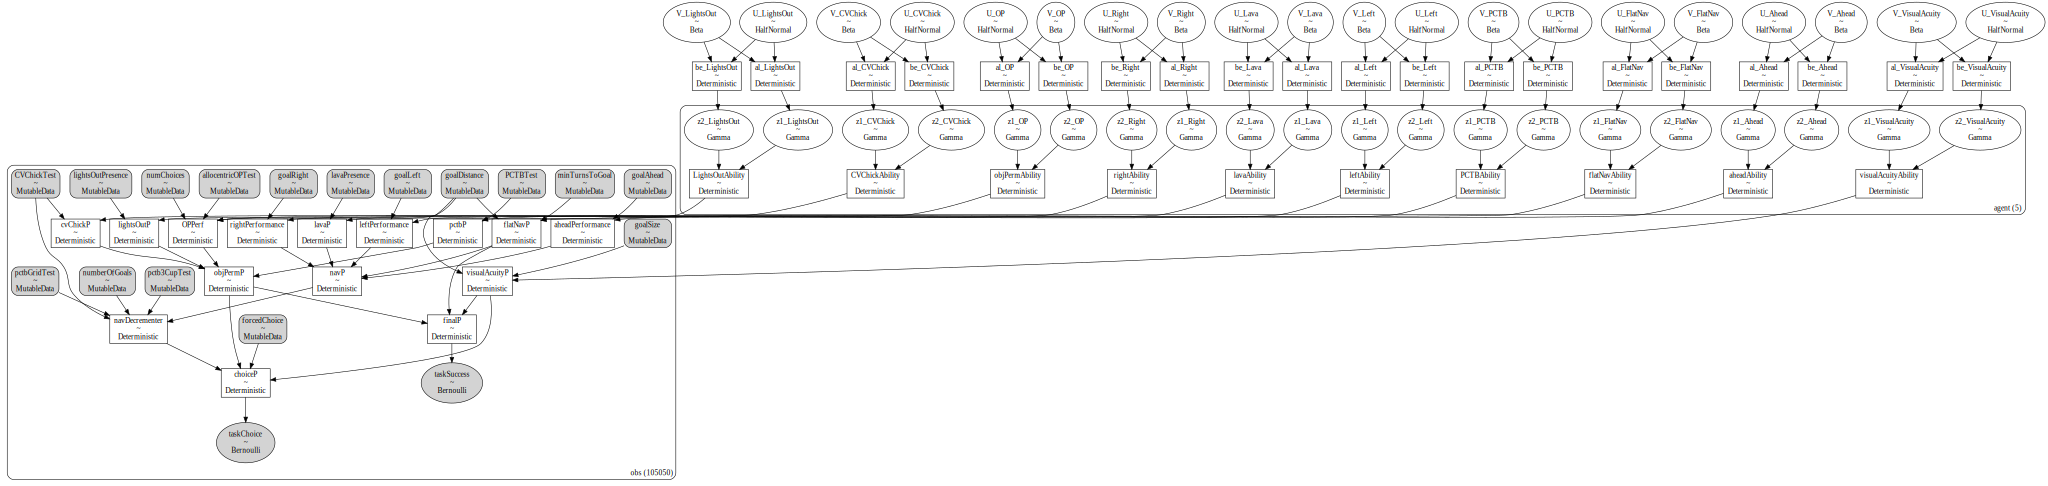

In [44]:
pm.model_to_graphviz(hierarchical_model)

In [45]:
with hierarchical_model:
    data_all = pm.sample(2000, target_accept=0.95)

SamplingError: ignored

In [46]:
hierarchical_model.debug()

point={'V_Lava_logodds__': array(0.), 'U_Lava_log__': array(2.30258509), 'V_Ahead_logodds__': array(0.), 'U_Ahead_log__': array(2.30258509), 'V_Left_logodds__': array(0.), 'U_Left_log__': array(2.30258509), 'V_Right_logodds__': array(0.), 'U_Right_log__': array(2.30258509), 'V_CVChick_logodds__': array(0.), 'U_CVChick_log__': array(2.30258509), 'V_PCTB_logodds__': array(0.), 'U_PCTB_log__': array(2.30258509), 'V_LightsOut_logodds__': array(0.), 'U_LightsOut_log__': array(2.30258509), 'V_OP_logodds__': array(0.), 'U_OP_log__': array(2.30258509), 'V_VisualAcuity_logodds__': array(0.), 'U_VisualAcuity_log__': array(2.30258509), 'V_FlatNav_logodds__': array(0.), 'U_FlatNav_log__': array(2.30258509), 'z1_Lava_log__': array([1.60943791, 1.60943791, 1.60943791, 1.60943791, 1.60943791]), 'z2_Lava_log__': array([1.60943791, 1.60943791, 1.60943791, 1.60943791, 1.60943791]), 'z1_Ahead_log__': array([1.60943791, 1.60943791, 1.60943791, 1.60943791, 1.60943791]), 'z2_Ahead_log__': array([1.60943791,